In [2]:
import os
from os import path as osp
import json
from PIL import Image
import zarr
import numpy as np
import torch

from modules.utils.image_utils import plot_tensor, crop_box, transform, to_tensor

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
root_dir = '../H36M/'

In [5]:
dirnames = sorted([dirname for dirname in os.listdir(osp.join(root_dir, 'images')) if dirname.startswith('s_')])

In [6]:
dirnames

['s_07_act_09_subact_01_ca_01',
 's_07_act_09_subact_01_ca_02',
 's_07_act_09_subact_01_ca_03',
 's_07_act_09_subact_01_ca_04']

In [13]:
annotation_files =  [image_name for image_name in os.listdir(osp.join(root_dir, 'annotations')) if image_name.endswith('_data.json')]
annotation_files

['Human36M_subject9_data.json',
 'Human36M_subject11_data.json',
 'Human36M_subject8_data.json',
 'Human36M_subject5_data.json',
 'Human36M_subject6_data.json',
 'Human36M_subject1_data.json',
 'Human36M_subject7_data.json']

In [14]:
with open(osp.join(root_dir, 'annotations', annotation_files[-2])) as json_file:
            annotations = json.load(json_file)

In [15]:
annotations['images']

[{'id': 0,
  'file_name': 's_01_act_02_subact_01_ca_01/s_01_act_02_subact_01_ca_01_000001.jpg',
  'width': 1000,
  'height': 1002,
  'subject': 1,
  'action_name': 'Directions',
  'action_idx': 2,
  'subaction_idx': 1,
  'cam_idx': 1,
  'frame_idx': 0},
 {'id': 1,
  'file_name': 's_01_act_02_subact_01_ca_01/s_01_act_02_subact_01_ca_01_000002.jpg',
  'width': 1000,
  'height': 1002,
  'subject': 1,
  'action_name': 'Directions',
  'action_idx': 2,
  'subaction_idx': 1,
  'cam_idx': 1,
  'frame_idx': 1},
 {'id': 2,
  'file_name': 's_01_act_02_subact_01_ca_01/s_01_act_02_subact_01_ca_01_000003.jpg',
  'width': 1000,
  'height': 1002,
  'subject': 1,
  'action_name': 'Directions',
  'action_idx': 2,
  'subaction_idx': 1,
  'cam_idx': 1,
  'frame_idx': 2},
 {'id': 3,
  'file_name': 's_01_act_02_subact_01_ca_01/s_01_act_02_subact_01_ca_01_000004.jpg',
  'width': 1000,
  'height': 1002,
  'subject': 1,
  'action_name': 'Directions',
  'action_idx': 2,
  'subaction_idx': 1,
  'cam_idx': 1,
  '

In [ ]:
def get_idx_from_name(root_dir='../H36M'): 
    name_ids={}
    annotation_files =  [image_name for image_name in os.listdir(osp.join(root_dir, 'annotations')) if image_name.endswith('_data.json')]
    for annotation_file in annotation_files:
        with open(osp.join(root_dir, 'annotations', annotation_file)) as json_file:
            annotations = json.load(json_file)
        for image in annotations['images']:
            name_ids[image['action_name']] = image['action_idx']
            

In [6]:
def get_bbox_from_json(root_dir='../H36M', border_scale=1.3): 
    bboxes={}
    annotation_files =  [image_name for image_name in os.listdir(osp.join(root_dir, 'annotations')) if image_name.endswith('_data.json')]
    for annotation_file in annotation_files:
        with open(osp.join(root_dir, 'annotations', annotation_file)) as json_file:
            annotations = json.load(json_file)
        for image, annotation in zip(annotations['images'], annotations['annotations']):
            x_border = image['width']
            y_border = image['height']
            x_min, y_min, width, height = annotation['bbox']
            x_max = x_min+width
            y_max = y_min+height
            delta_x = width * ((border_scale-1) / 2)
            delta_y = height * ((border_scale-1) / 2)
            delta = max(delta_x, delta_y)
            x_min = max(0, int(x_min-delta))
            y_min = max(0, int(y_min-delta))
            x_max = min(x_border, int(x_max+delta))
            y_max = min(y_border, int(y_max+delta))
            bboxes[osp.join(root_dir, 'images', image['file_name'])] = [int(x_min), int(y_min), int(x_max), int(y_max)]
    return bboxes

In [8]:
bboxes = get_bbox_from_json()


In [9]:
with open('./data/h36m_bboxes.json', 'w') as fp:
    json.dump(bboxes, fp)

In [12]:
 with open('./data/h36m_bboxes.json', 'r') as json_file:
            bboxes = json.load(json_file)

In [10]:
'../H36M/images/s_07_act_02_subact_01_ca_04/s_07_act_02_subact_01_ca_04_000001.jpg' in bboxes.keys()#['../H36M/images/s_07_act_09_subact_01_ca_01/s_07_act_09_subact_01_ca_04_000001.jpg']

True

In [13]:
def extract_subject_act_subact(dirname):
    subject = int(dirname[2:4])
    act = int(dirname[9:11])
    subact = int(dirname[19:21])
    return subject, act, subact

In [14]:
keys = sorted(list({extract_subject_act_subact(dirname) for dirname in dirnames}))

In [15]:
def box_from_mask(mask, border_scale=1.3):
    rows = torch.tensor(mask!=0, dtype=torch.int8).max(dim=1)[0]
    cols = torch.tensor(mask!=0, dtype=torch.int8).max(dim=0)[0]
    weight=torch.tensor([1,-1], dtype=torch.int8).view(1,1,-1)
    rows_conv = torch.conv1d(rows.view(1,1,-1), weight=weight, padding=1).view(-1)
    cols_conv = torch.conv1d(cols.view(1,1,-1), weight=weight, padding=1).view(-1)
    x_min = cols_conv.argmin().item()
    x_max = cols_conv.argmax().item()-1
    y_min = rows_conv.argmin().item()
    y_max = rows_conv.argmax().item()-1
    
    width = x_max - x_min
    delta_x = width * ((border_scale-1) / 2)
    
    height = y_max - y_min
    delta_y = height * ((border_scale-1) / 2)
    
    delta = max(delta_x, delta_y)
    y_border, x_border = mask.shape
    x_min = max(0, int(x_min-delta))
    y_min = max(0, int(y_min-delta))
    x_max = min(x_border, int(x_max+delta))
    y_max = min(y_border, int(y_max+delta))
    
    return (x_min, y_min, x_max, y_max)

4533 453
../H36M/images/s_07_act_09_subact_01_ca_04


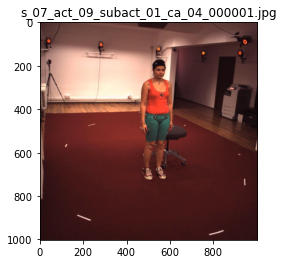

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


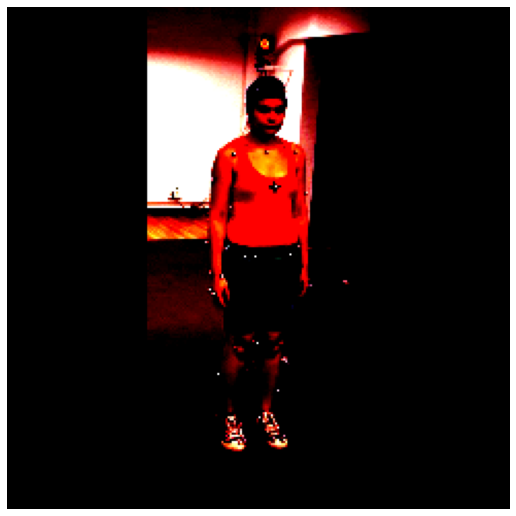

torch.Size([3, 244, 244])


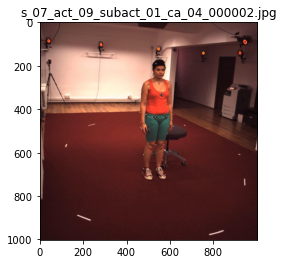

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


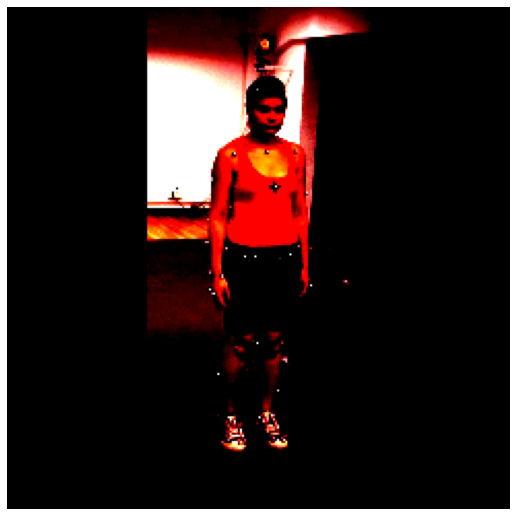

torch.Size([3, 244, 244])


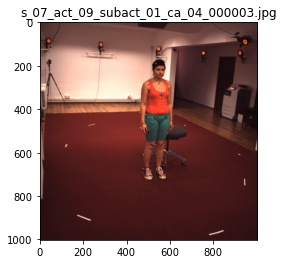

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


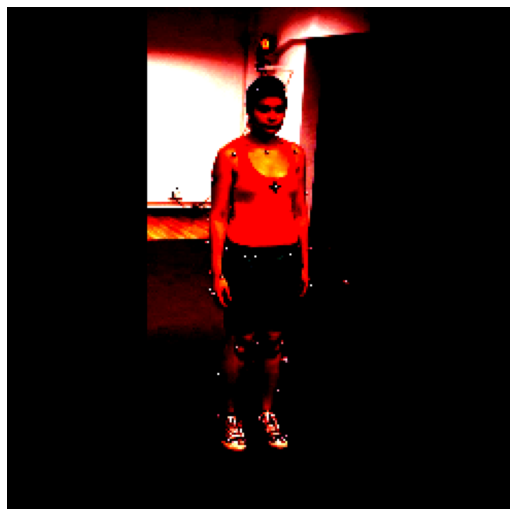

torch.Size([3, 244, 244])


In [ ]:
img_size = 244

for subject, act, subact in keys:
    # TODO: create f'{dirname}.zarr' with shape (T,4,3,H,W) and f'{dirname}_mask.zarr' of shape (T,4,H,W)
    # where T corresponds to the sequence length, 4 is number of cameras,
    # 3 for RGB channels and H,W denote image width and height repectively.
    dirname = f's_{subject:02d}_act_{act:02d}_subact_{subact:02d}'
    
    img_zarr_path = osp.join(root_dir, 'img_zarr', dirname + '.zarr')
    mask_zarr_path = osp.join(root_dir, 'img_zarr', dirname +  '_mask.zarr')  
    
    len_seq = len(os.listdir(osp.join(root_dir, 'images', dirname+ '_ca_01')))-1 #TODO !!
    num_chunks = len_seq//10
    print(len_seq, num_chunks)
    img_zarr = zarr.open(img_zarr_path, mode='w', shape=(len_seq, 4, 3, img_size, img_size), chunks=(num_chunks, None), dtype='float32')
    mask_zarr = zarr.open(mask_zarr_path, mode='w', shape=(len_seq, 4, img_size, img_size), chunks=(num_chunks, None), dtype='float32')
    
    for cam in range(1,5):
        
        cam_id=4
        dirname_cam = dirname + f'_ca_{cam_id:02d}'
        dirpath = osp.join(root_dir, 'images', dirname_cam)
        print(dirpath)
        
        file_names = os.listdir(dirpath)
        file_names = sorted([file_name for file_name in file_names if file_name.startswith(dirname)])
        image_names = [file_name for file_name in file_names if not file_name.endswith('_mask.jpg')]
        mask_names = [file_name for file_name in file_names if file_name.endswith('_mask.jpg')]
        
        names_list = image_names if not mask_names else zip(image_names, mask_names)
        for t, names in enumerate(names_list):
            if mask_names:
                image_name, mask_names = names
                mask_id = int(mask_name[28:34])
                assert (t+1) == image_id == mask_id
            else: 
                image_name = names    
            image_id = int(image_name[28:34])            
            # load image
            image_path = osp.join(dirpath, image_name)
            image = np.array(Image.open(image_path))
            plt.imshow(image)
            plt.title(image_name)
            plt.show()
            
            x_min, y_min, x_max, y_max = bboxes[image_path]
            image = image[y_min:y_max, x_min:x_max]
            image = transform(to_tensor(image), img_size=img_size)
            plot_tensor(image)
            print(image.shape)
            img_zarr[t, cam_id-1] = image
            
            if mask_names:
                mask_path = osp.join(dirpath, mask_name)
                mask = np.array(Image.open(mask_path))
                plt.imshow(mask, cmap='gray')
                plt.title(mask_name)
                plt.show()
                #x_min, y_min, x_max, y_max = box_from_mask(mask)
                mask = mask[y_min:y_max, x_min:x_max]
                mask = transform(to_tensor(mask), img_size=img_size)
                plot_tensor(mask)
                mask_zarr[t, cam_id] = mask
            
          
            
            # TODO: write image to Zarr
            # zarr_image[t,cam_id] = image
            # zarr_mask[t,cam_id] = mask
            

In [66]:
test_zarr = zarr.open(img_zarr_path, mode='w', shape=(len_seq, 4, 3, img_size, img_size), chunks=(num_chunks, None), dtype='float32')

In [67]:
test_zarr

<zarr.core.Array (4533, 4, 3, 244, 244) float32>

In [68]:
a = torch.ones(3,244,244)

In [69]:
print(a.dtype,a.shape)

torch.float32 torch.Size([3, 244, 244])


In [70]:
print(image.dtype, image.shape)

torch.float32 torch.Size([3, 224, 224])


In [71]:
test_zarr[0,0] = a

In [72]:
test_zarr[0,0]

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)

In [75]:
test_zarr[0,0] = image.detach().numpy()

ValueError: parameter 'value': expected array with shape (3, 244, 244), got (3, 224, 224)